In [1]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up the source path (adjust as needed for your project structure)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import custom functions for adapted measures and optimal solvers
from optimal_code.utils import *
from optimal_code.optimal_solver import *


from trees.build_trees_from_paths import *
from trees.treeVisualization import *
from adapted_empirical_measure.AEM_grid import *

In [2]:
# ----------------------------------------------------------------------------
# Define an AR(3) simulation function with Gaussian noise
# ----------------------------------------------------------------------------
def ar3_simulation(n_sample, T, phi, sigma, seed):
    """
    Simulates an AR(3) process with Gaussian noise:
    
        X_t = phi[0]*X_{t-1} + phi[1]*X_{t-2} + phi[2]*X_{t-3} + sigma * Z_t,
    
    where Z_t ~ N(0,1). The process is simulated for T time steps 
    (excluding the initial conditions). For an AR(3) process, we need 
    three initial values; here, we set X[0], X[1], and X[2] to 0.
    
    Parameters:
      n_sample: int
          Number of sample paths.
      T: int
          Total number of time steps (must be >= 3). The returned array
          will have shape (T+1, n_sample), with indices 0,...,T.
      phi: list or array of length 3
          AR(3) coefficients.
      sigma: float
          Noise scale.
      seed: int
          Random seed.
      
    Returns:
      X: np.ndarray of shape (T+1, n_sample)
    """
    np.random.seed(seed)
    X = np.zeros((T+1, n_sample))
    # Set initial conditions for t = 0, 1, 2
    X[0, :] = 0.0
    X[1, :] = 0.0
    X[2, :] = 0.0
    for t in range(3, T+1):
        Z = np.random.normal(loc=0.0, scale=1.0, size=n_sample)
        X[t, :] = phi[0]*X[t-1, :] + phi[1]*X[t-2, :] + phi[2]*X[t-3, :] + sigma * Z
    return X[2:,:]

In [3]:
def generate_ar3_lower_triangular_scaled(T, phi, sigma):
    """
    Generate the lower-triangular matrix L scaled by sigma for an AR(3) process defined as:
    
        X_t = phi[0]*X_{t-1} + phi[1]*X_{t-2} + phi[2]*X_{t-3} + sigma * Z_t,
    
    where the process from t = 3 to t = T is represented as:
        X_t = sum_{j=3}^{t} psi_{t-j} * (sigma * Z_j).
    
    The impulse-response coefficients psi_k are computed by:
        psi_0 = 1,
        psi_1 = phi[0],
        psi_2 = phi[0]^2 + phi[1],
    and for k >= 3,
        psi_k = phi[0]*psi_{k-1} + phi[1]*psi_{k-2} + phi[2]*psi_{k-3].
    
    The lower-triangular matrix L (of shape (T-2, T-2)) is defined as:
        L[i, j] = psi[i-j] for i >= j, and 0 otherwise.
    Multiplying L by sigma scales the mapping from the standard normal innovations Z.
    
    Parameters:
      T: int
         Total number of time steps (must be >= 3).
      phi: list or np.array of length 3
         AR(3) coefficients.
      sigma: float
         Noise scale.
    
    Returns:
      L_scaled: np.ndarray of shape (T-2, T-2)
         Lower-triangular matrix scaled by sigma.
    """
    n = T - 2  # Number of time steps from t = 3 to T
    psi = np.zeros(n)
    psi[0] = 1.0  # psi_0
    
    if n > 1:
        psi[1] = phi[0]  # psi_1
    if n > 2:
        psi[2] = phi[0] * psi[1] + phi[1] * psi[0]  # psi_2 = phi[0]^2 + phi[1]
    
    for k in range(3, n):
        psi[k] = phi[0] * psi[k-1] + phi[1] * psi[k-2] + phi[2] * psi[k-3]
    
    # Construct the lower-triangular matrix L
    L = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1):  # Only fill for j <= i
            L[i, j] = psi[i - j]
    
    # Scale the matrix by sigma
    L_scaled = sigma * L
    return L_scaled



# To check the goal here is to have a model with non markovian Behavior

Parameter choosed kind of randomly we care about the past -> 3 time step looking back not only 1

In [23]:
# ----------------------------------------------------------------------------
# Experiment Parameters
# ----------------------------------------------------------------------------
T = 7               # Total time steps (we simulate indices 0,1,2 as initial and t=3,4 by AR recursion)

# AR(3) parameters for Process X (e.g., more persistent, lower volatility)
phi_x = [0.2, 0.8, 0.4]  
sigma_x = 0.9

# AR(3) parameters for Process Y (e.g., less persistent, higher volatility)
phi_y = [0.3, 0.1, 0.05]
sigma_y = 0.5

[[0.9     0.      0.      0.      0.     ]
 [0.18    0.9     0.      0.      0.     ]
 [0.756   0.18    0.9     0.      0.     ]
 [0.6552  0.756   0.18    0.9     0.     ]
 [0.80784 0.6552  0.756   0.18    0.9    ]]
[[0.5     0.      0.      0.      0.     ]
 [0.15    0.5     0.      0.      0.     ]
 [0.095   0.15    0.5     0.      0.     ]
 [0.0685  0.095   0.15    0.5     0.     ]
 [0.03755 0.0685  0.095   0.15    0.5    ]]
3.3961434641000015


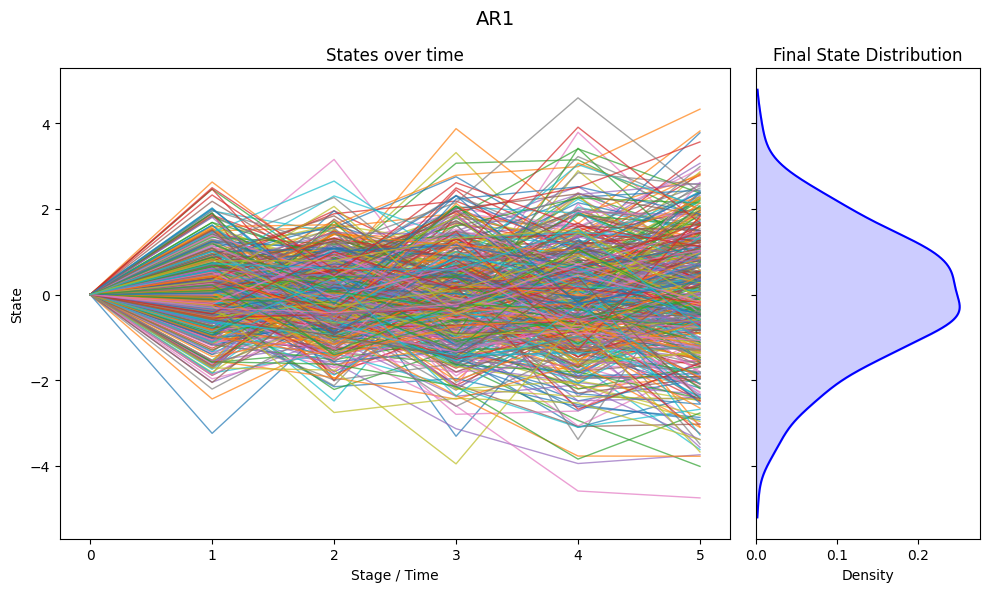

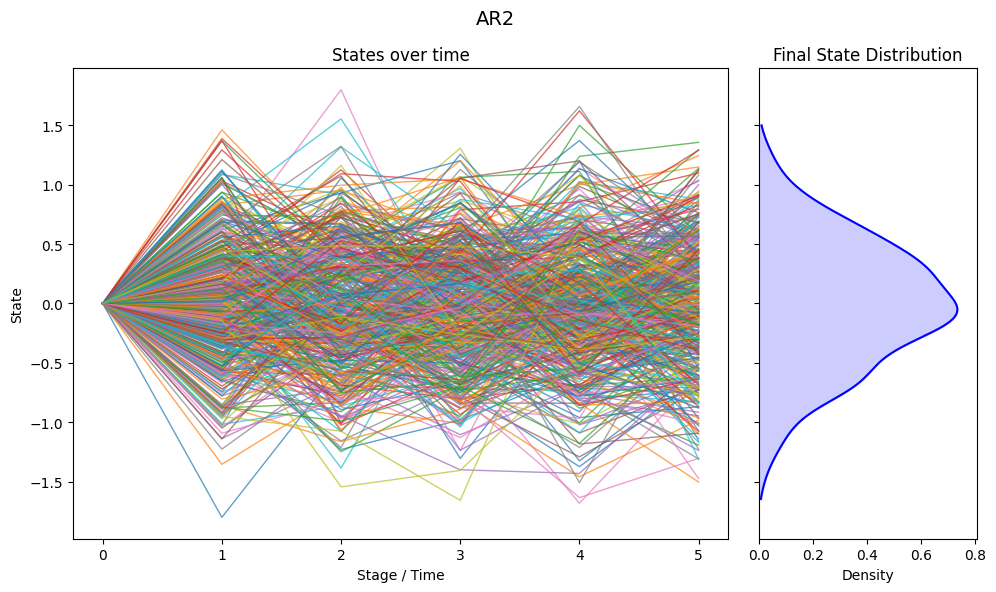

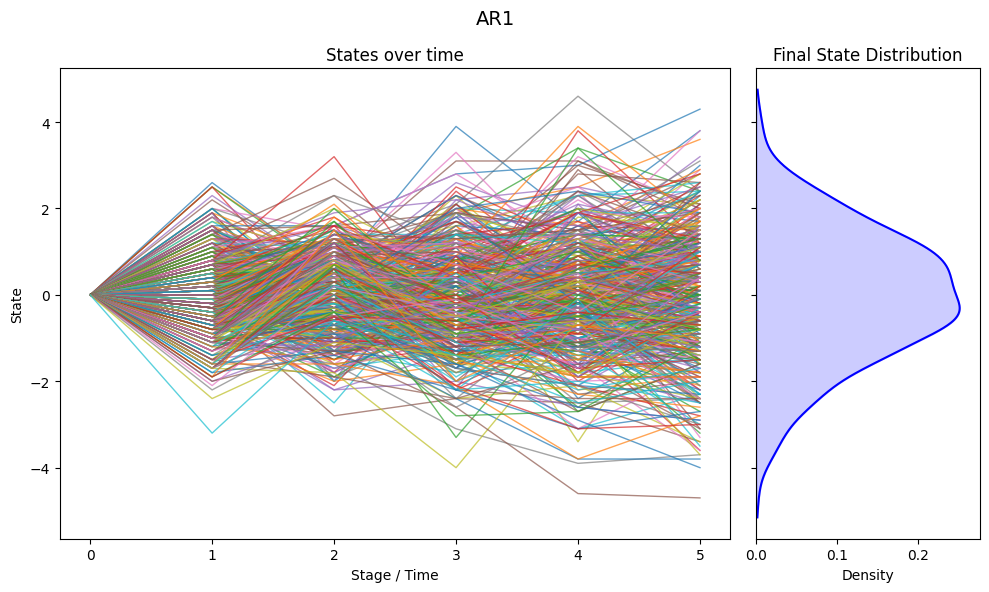

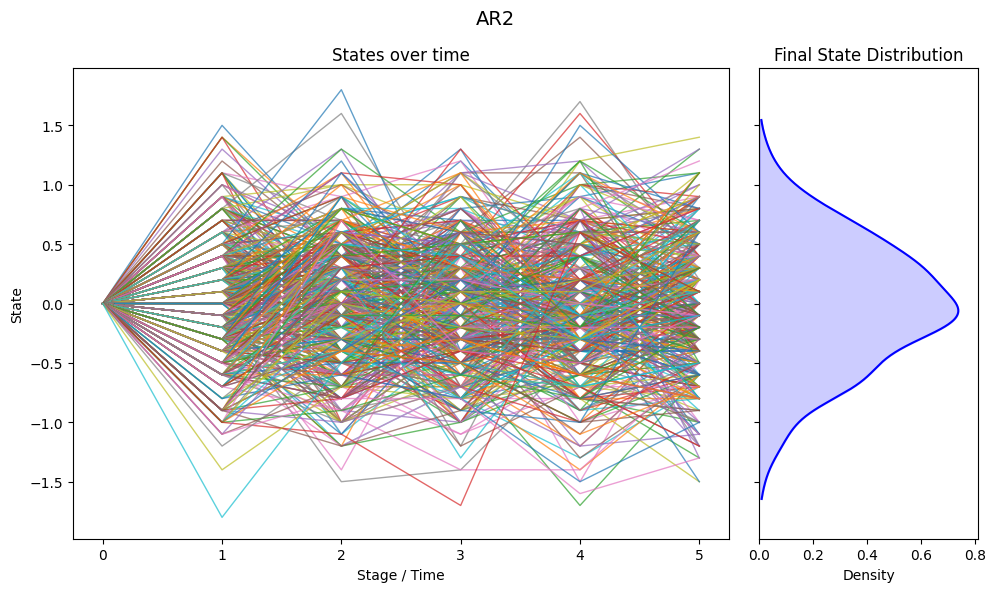

In [24]:
n_sample = 500
seed = 44

L = generate_ar3_lower_triangular_scaled(T, phi_x, sigma_x)
M = generate_ar3_lower_triangular_scaled(T, phi_y, sigma_y)
print(L)
print(M)

print(adapted_wasserstein_squared(L@L.T, M@M.T))
random_seed = np.random.randint(10000)
X, _ = Lmatrix2paths(L, n_sample, seed=random_seed, verbose=False)
Y, _ = Lmatrix2paths(M, n_sample, seed=random_seed, verbose=False)

iid_weights = np.full(n_sample, 1 / n_sample)

root = build_tree_from_paths(X.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="AR1",
)

root = build_tree_from_paths(Y.T, iid_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="AR2",
)

fixed_grid = 0.1 # <- Large grid for visualization

new_sample_paths, new_weights = uniform_empirical_grid_measure(X.T, fixed_grid, use_weights=True) # Grid with number of grid points as in papers [0,1] divided into: 1/N^r with R=1/(T+1).
root = build_tree_from_paths(new_sample_paths, new_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="AR1",
)

new_sample_paths, new_weights = uniform_empirical_grid_measure(Y.T, fixed_grid, use_weights=True) # Grid with number of grid points as in papers [0,1] divided into: 1/N^r with R=1/(T+1).
root = build_tree_from_paths(new_sample_paths, new_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="AR2",
)

In [25]:
sample_sizes = [500, 1000, 2000, 3000, 5000, 7500, 10000]  # Small number of samples <- just to run something quickly

n_runs = 1         # Number of independent runs per sample size

# small number of samples and not optimal gird size it is just to run something

In [ ]:
# ----------------------------------------------------------------------------
# Run Experiments Over Different Sample Sizes
# ----------------------------------------------------------------------------

results = {}


for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    for run in range(n_runs):
        # Use a new random seed for each run
        seed = np.random.randint(10000)
        
        # Simulate AR(3) paths for both processes
        X, A = Lmatrix2paths(L, n_sample, seed=seed, verbose=False)
        Y, B = Lmatrix2paths(M, n_sample, seed=seed, verbose=False)
        
        benchmark = adapted_wasserstein_squared(A, B)
        # Convert raw paths to adapted paths via grid quantization
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping using the union of all grid values
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        # Ensure proper ordering: transpose so shape becomes (n_sample, T+1)
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Obtain the conditional measures (non-Markovian)
        mu_x = qpath2mu_x(qX)
        nu_y = qpath2mu_x(qY)
        
        # Represent these measures as lists for the nested solver
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)
        
        # Compute the adapted Wasserstein squared distance using the non-Markovian solver
        t_start = time.perf_counter()
        AW_2square = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                      nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                      n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    results[n_sample] = {"distances": distances_runs, "times": times_runs, "benchmark": benchmark}


Running experiments for sample size: 500


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 309.01it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 201.13it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 159.30it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 184.55it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 729.32it/s]


Sample size 500, Run 1: AW_2^2 = 4.8859, Time = 4.6145 s

Running experiments for sample size: 1000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 169.56it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 163.13it/s]

In [ ]:
# ----------------------------------------------------------------------------
# Aggregating Results
# ----------------------------------------------------------------------------
sample_list = sorted(results.keys())
mean_distances = []
std_distances = []
mean_times = []
std_times = []
mean_abs_errors = []
std_abs_errors = []
benchmarks = []  # (should be the same for all runs)

for n_sample in sample_list:
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    
    mean_distances.append(np.mean(dists))
    std_distances.append(np.std(dists))
    mean_times.append(np.mean(times))
    std_times.append(np.std(times))
    abs_errors = np.abs(dists - bench)
    mean_abs_errors.append(np.mean(abs_errors))
    std_abs_errors.append(np.std(abs_errors))
    benchmarks.append(bench)

# ----------------------------------------------------------------------------
# Plotting the Results
# ----------------------------------------------------------------------------

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmarks[0], color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Adapted Wasserstein Squared Distance")
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid Quantization with Grid = 0.01)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Computation Time (seconds)")
plt.title("Computation Time vs. Sample Size\n(Fixed Grid Quantization with Grid = 0.01)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|")
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid Quantization with Grid = 0.01)")
plt.legend()
plt.grid(True)
plt.show()